In [38]:
# !pip install pandas numpy

In [39]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree


In [40]:
airline_df = pd.read_csv("datasets/Airline Dataset Updated - v2.csv")
delta_df = pd.read_csv("datasets/Delta_Airline_Review_Dataset-Asof02172023.csv")

print(f'airline_df.shape: {airline_df.shape}')
print(f'delta_df.shape: {delta_df.shape}')


airline_df.shape: (98619, 15)
delta_df.shape: (2689, 8)


### Data Cleaning

In [41]:
clean_col = ""
for col in delta_df.columns:
    clean_col = col.strip()
    delta_df.rename(columns={col: clean_col}, inplace=True)

### Satisfaction Analysis

In [42]:
delta_df.head()


,Customer_ID,star rating,date,Seat Type,routes,traveler_types,country,reviews
0,1,4,17th February 2023,Economy Class,New York to Tel Aviv,Solo Leisure,United States,"✅ Trip Verified | First, travel starts 6pm ar..."
1,2,1,16th February 2023,Economy Class,Milwaukee to Ft Lauderdale,Business,United States,✅ Trip Verified | Delta did not issue any wea...
2,3,1,10th February 2023,Economy Class,New York to Charlotte,Business,United States,"✅ Trip Verified | Per our pilot, there would ..."
3,4,1,8th February 2023,Premium Economy,Atlanta to Cape Town,Family Leisure,United States,✅ Trip Verified | We flew from Atlanta to Cap...
4,5,2,6th February 2023,Economy Class,Dallas to Atlanta,Solo Leisure,United Kingdom,✅ Trip Verified | Checkin staff always seem u...


In [43]:
# Encode categorical features
label_encoders = {}
for col in ['date', 'Seat Type', 'traveler_types', 'routes', 'country']:
    if col in delta_df.columns:
        le = LabelEncoder()
        delta_df[col] = le.fit_transform(delta_df[col].astype(str))
        label_encoders[col] = le


# Features and target
X = delta_df[['date', 'traveler_types']]
y = delta_df['star rating']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model training
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [44]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = model.predict(X_test)
print("MSE:", mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

MSE: 14.931415407690412
R² Score: -0.2582944554748845


### Visualization Functions

In [45]:
def plot_decision_tree(model, feature_names, max_depth=3, figsize=(20,10)):
    plt.figure(figsize=figsize)
    # Get a single tree from the forest
    tree = model.estimators_[0]
    plot_tree(tree, 
             feature_names=feature_names,
             max_depth=max_depth,
             filled=True,
             rounded=True)
    plt.show()

def plot_feature_importance(model, feature_names, figsize=(10,6)):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=figsize)
    plt.title('Feature Importance in Delta Airlines Reviews')
    plt.bar(range(len(importances)), 
            importances[indices],
            align='center')
    plt.xticks(range(len(importances)), 
               [feature_names[i] for i in indices], 
               rotation=45,
               ha='right')
    plt.tight_layout()
    plt.show()

### Visualization

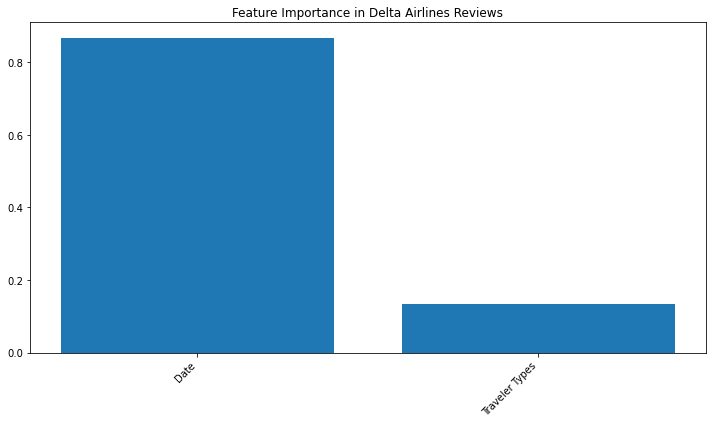

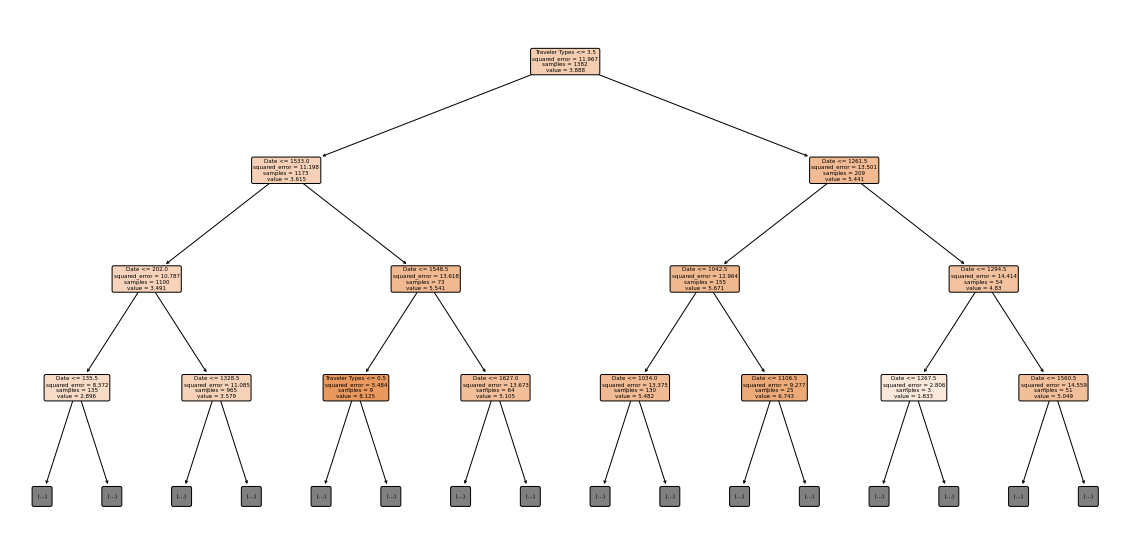

In [46]:
# Visualize feature importance
feature_names = ['Date', 'Traveler Types']  # Your actual feature names
plot_feature_importance(
    model=model,
    feature_names=feature_names
)

# Visualize a single tree from the forest
plot_decision_tree(
    model=model,
    feature_names=feature_names,
    max_depth=3
)

<Figure size 720x432 with 0 Axes>

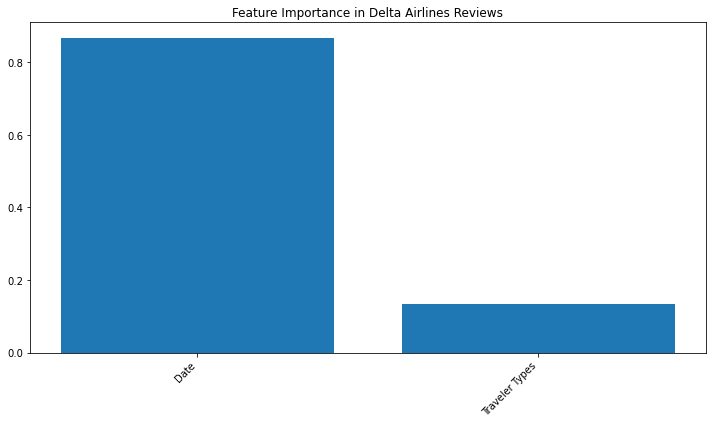

<Figure size 1440x720 with 0 Axes>

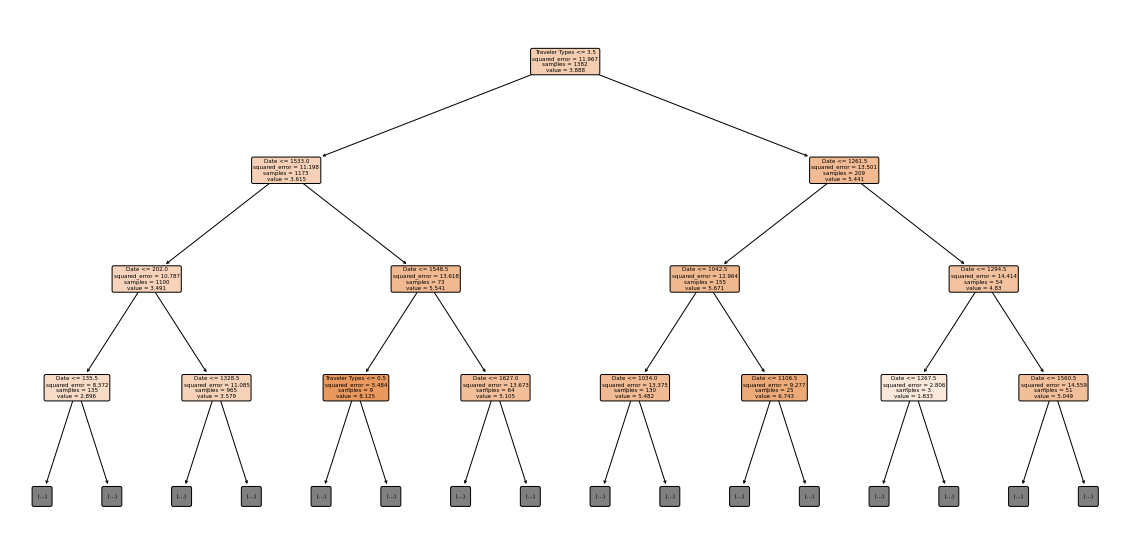

In [47]:
# Save visualizations
import os

# Create images directory if it doesn't exist
if not os.path.exists('images'):
    os.makedirs('images')

# Save feature importance plot
plt.figure(figsize=(10,6))
plot_feature_importance(model=model, feature_names=feature_names)
plt.savefig('images/feature_importance.png', bbox_inches='tight', dpi=300)
plt.close()

# Save decision tree plot
plt.figure(figsize=(20,10))
plot_decision_tree(model=model, feature_names=feature_names, max_depth=3)
plt.savefig('images/decision_tree.png', bbox_inches='tight', dpi=300)
plt.close()

def update_readme_with_results(mse, r2_score):
    """Update README with model results and images"""
    with open('README.md', 'r') as file:
        content = file.read()
    
    results = f"""
### Model Results
- Mean Squared Error: {mse:.2f}
- R² Score: {r2_score:.2f}

#### Feature Importance
![Feature Importance](images/feature_importance.png)
1. Date: Accounts for most of the variance in ratings
2. Traveler Types: Has less impact on ratings

#### Decision Tree Visualization
![Decision Tree](images/decision_tree.png)

#### Model Interpretation
- The current model shows poor performance (negative R² score) suggesting that:
  - We need more features (like Seat Type, Routes, Country)
  - Date might need better preprocessing (e.g., extract month, day of week)
  - Text analysis of reviews could provide valuable insights
  - Consider using more advanced models or ensemble methods
"""
    
    # Add results after the prediction section
    updated_content = content.replace(
        "2. Predicting customer satisfaction (Delta dataset)",
        "2. Predicting customer satisfaction (Delta dataset)\n" + results
    )
    
    with open('README.md', 'w') as file:
        file.write(updated_content)

# Update README with current results and images
update_readme_with_results(
    mse=mean_squared_error(y_test, y_pred),
    r2_score=r2_score(y_test, y_pred)
)

# Add images folder to .gitignore
with open('.gitignore', 'a') as f:
    f.write('\n# Ignore images folder\n!images/\n')